In [ ]:
# install package

!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%%
# import module

from cmath import sin
import random
import collections
import math
import gym
import numpy as np
import Box2D
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import copy

import matplotlib.pyplot as plt



torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
torch.backends.deterministic = True
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
# DQN algorithm

class LunarLanderAgent(object):
    def __init__(self, gamma,max_memory,eps_decay,lr,batch_size):#(0.99,5000000, 0.994, 0.0003, 64)
        self.env = gym.make('LunarLander-v2')
        self.nn_best = NeuralNetwork()
        self.nn = NeuralNetwork()
        self.gamma =gamma
        self.memory = collections.deque(maxlen=max_memory)
        # self.n = 0.01
        self.rewards = []
        self.success = {"bool": False, "episode": -1, "reward": -1}
        self.steps = 0
        self.history_length = 4
        self.final_eps=0.01
        self.eps_decay = eps_decay
        self.no_op_max = 30
        self.lr = lr
        self.batch_size = batch_size
        

        self.nn_best = copy.deepcopy(self.nn)


    def get_action(self, state, e):

        if np.random.random() < e:
            action = self.env.action_space.sample()
        else:
            with torch.no_grad():
                action = (np.argmax(self.nn(torch.from_numpy(np.array(state).astype(np.float32))))).item()        
        return action  
                

    def nn_train(self): 
        loss_function = nn.L1Loss()
        optimizer = torch.optim.Adam(self.nn.parameters(), lr= self.lr)
        
        inputs = []
        targets = []
        
        if len(self.memory)<self.batch_size:
            return 0
        miniBatch = random.sample(self.memory,self.batch_size )

        for x_t, a, r, x_t_1, done in miniBatch:
            
            y = 0
            if done:
                y += r
            else:
                y += r + self.gamma* max(self.nn_best(torch.from_numpy(np.array(x_t_1).astype(np.float32)))) # y: max Q_t+1

            y_ = self.nn(torch.from_numpy(np.array(x_t).astype(np.float32)))#  y_: Q_t
            y_[a] = y

            inputs.append(x_t)
            targets.append(y_.tolist())
        # print(inputs)
        # print(targets)
        
        dataset = myDataset(inputs, targets)
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size , shuffle=True)   
        for i, data in enumerate(train_dataloader, 0):
            train_features, train_labels = data

            optimizer.zero_grad()
            
            predict = self.nn(train_features)
            
            loss = loss_function(predict, train_labels)
            loss.backward()

            optimizer.step()

            
            
            
        self.nn_best = copy.deepcopy(self.nn)
            
            

    def train_agent(self, max_episode = 100000, max_step = 500):   
        
        
        for episode in range(max_episode):
            x_t = self.env.reset()
            s = x_t
            reward=0

            for step in range(max_step):
                self.steps += 1
                
                e = max(self.final_eps, self.eps_decay**episode)
                action = self.get_action(s, e)
                x_t_1, r, done, info = self.env.step(action)

                s_next = x_t_1
                reward += r

                self.memory.append([s, action, r, s_next, done])
                
                if episode > self.no_op_max and self.steps % self.history_length == 0:
                    
                    self.nn_train()
                    # if episode%50 == 0:
                    #     self.env.render()

                if done:
                    # self.env.close()
                    break
                s = s_next  

            self.rewards.append(reward)
            if episode%100 == 0:
              print("episode:", episode)


class NeuralNetwork(nn.Module):

    def __init__(self):

        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 4),
        )
        self.layers.apply(init_weights)

    def forward(self, x):
        return self.layers(x)

class myDataset(Dataset):
    def __init__(self, inputs, targets):

        self.inputs =torch.from_numpy(np.array(inputs))
        self.targets = torch.from_numpy(np.array(targets))

    def __len__(self):
        
        return len(self.inputs)

    def __getitem__(self, idx):
      
        return self.inputs[idx], self.targets[idx]

In [ ]:
# Run memoryReplay size study

#  memoryReplay size study (32,64,96,128)    (0.99,5000000, 0.994, 0.0003, 64)
rewards_memoryReplay_size = []

for memoryReplay_size in [5000,50000,500000,5000000]:
  agent = LunarLanderAgent(0.99,memoryReplay_size, 0.994, 0.0003, 64)
  agent.train_agent(max_episode = 2000)

  rewards_memoryReplay_size.append(agent.rewards)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 0
episode: 100
episode: 200
episode: 300
episode: 400
episode: 500
episode: 600
episode: 700
episode: 800
episode: 900
episode: 1000
episode: 1100
episode: 1200
episode: 1300
episode: 1400
episode: 1500
episode: 1600
episode: 1700
episode: 1800
episode: 1900
episode: 0
episode: 100
episode: 200
episode: 300
episode: 400
episode: 500
episode: 600
episode: 700
episode: 800
episode: 900
episode: 1000
episode: 1100
episode: 1200
episode: 1300
episode: 1400
episode: 1500
episode: 1600
episode: 1700
episode: 1800
episode: 1900
episode: 0
episode: 100
episode: 200
episode: 300
episode: 400
episode: 500
episode: 600
episode: 700
episode: 800
episode: 900
episode: 1000
episode: 1100
episode: 1200
episode: 1300
episode: 1400
episode: 1500
episode: 1600
episode: 1700
episode: 1800
episode: 1900
episode: 0
episode: 100
episode: 200
episode: 300
episode: 400
episode: 500
episode: 600
episode: 700
episode: 800
episode: 900
episode: 1000
episode: 1100
episode: 1200
episode: 1300
episode: 140

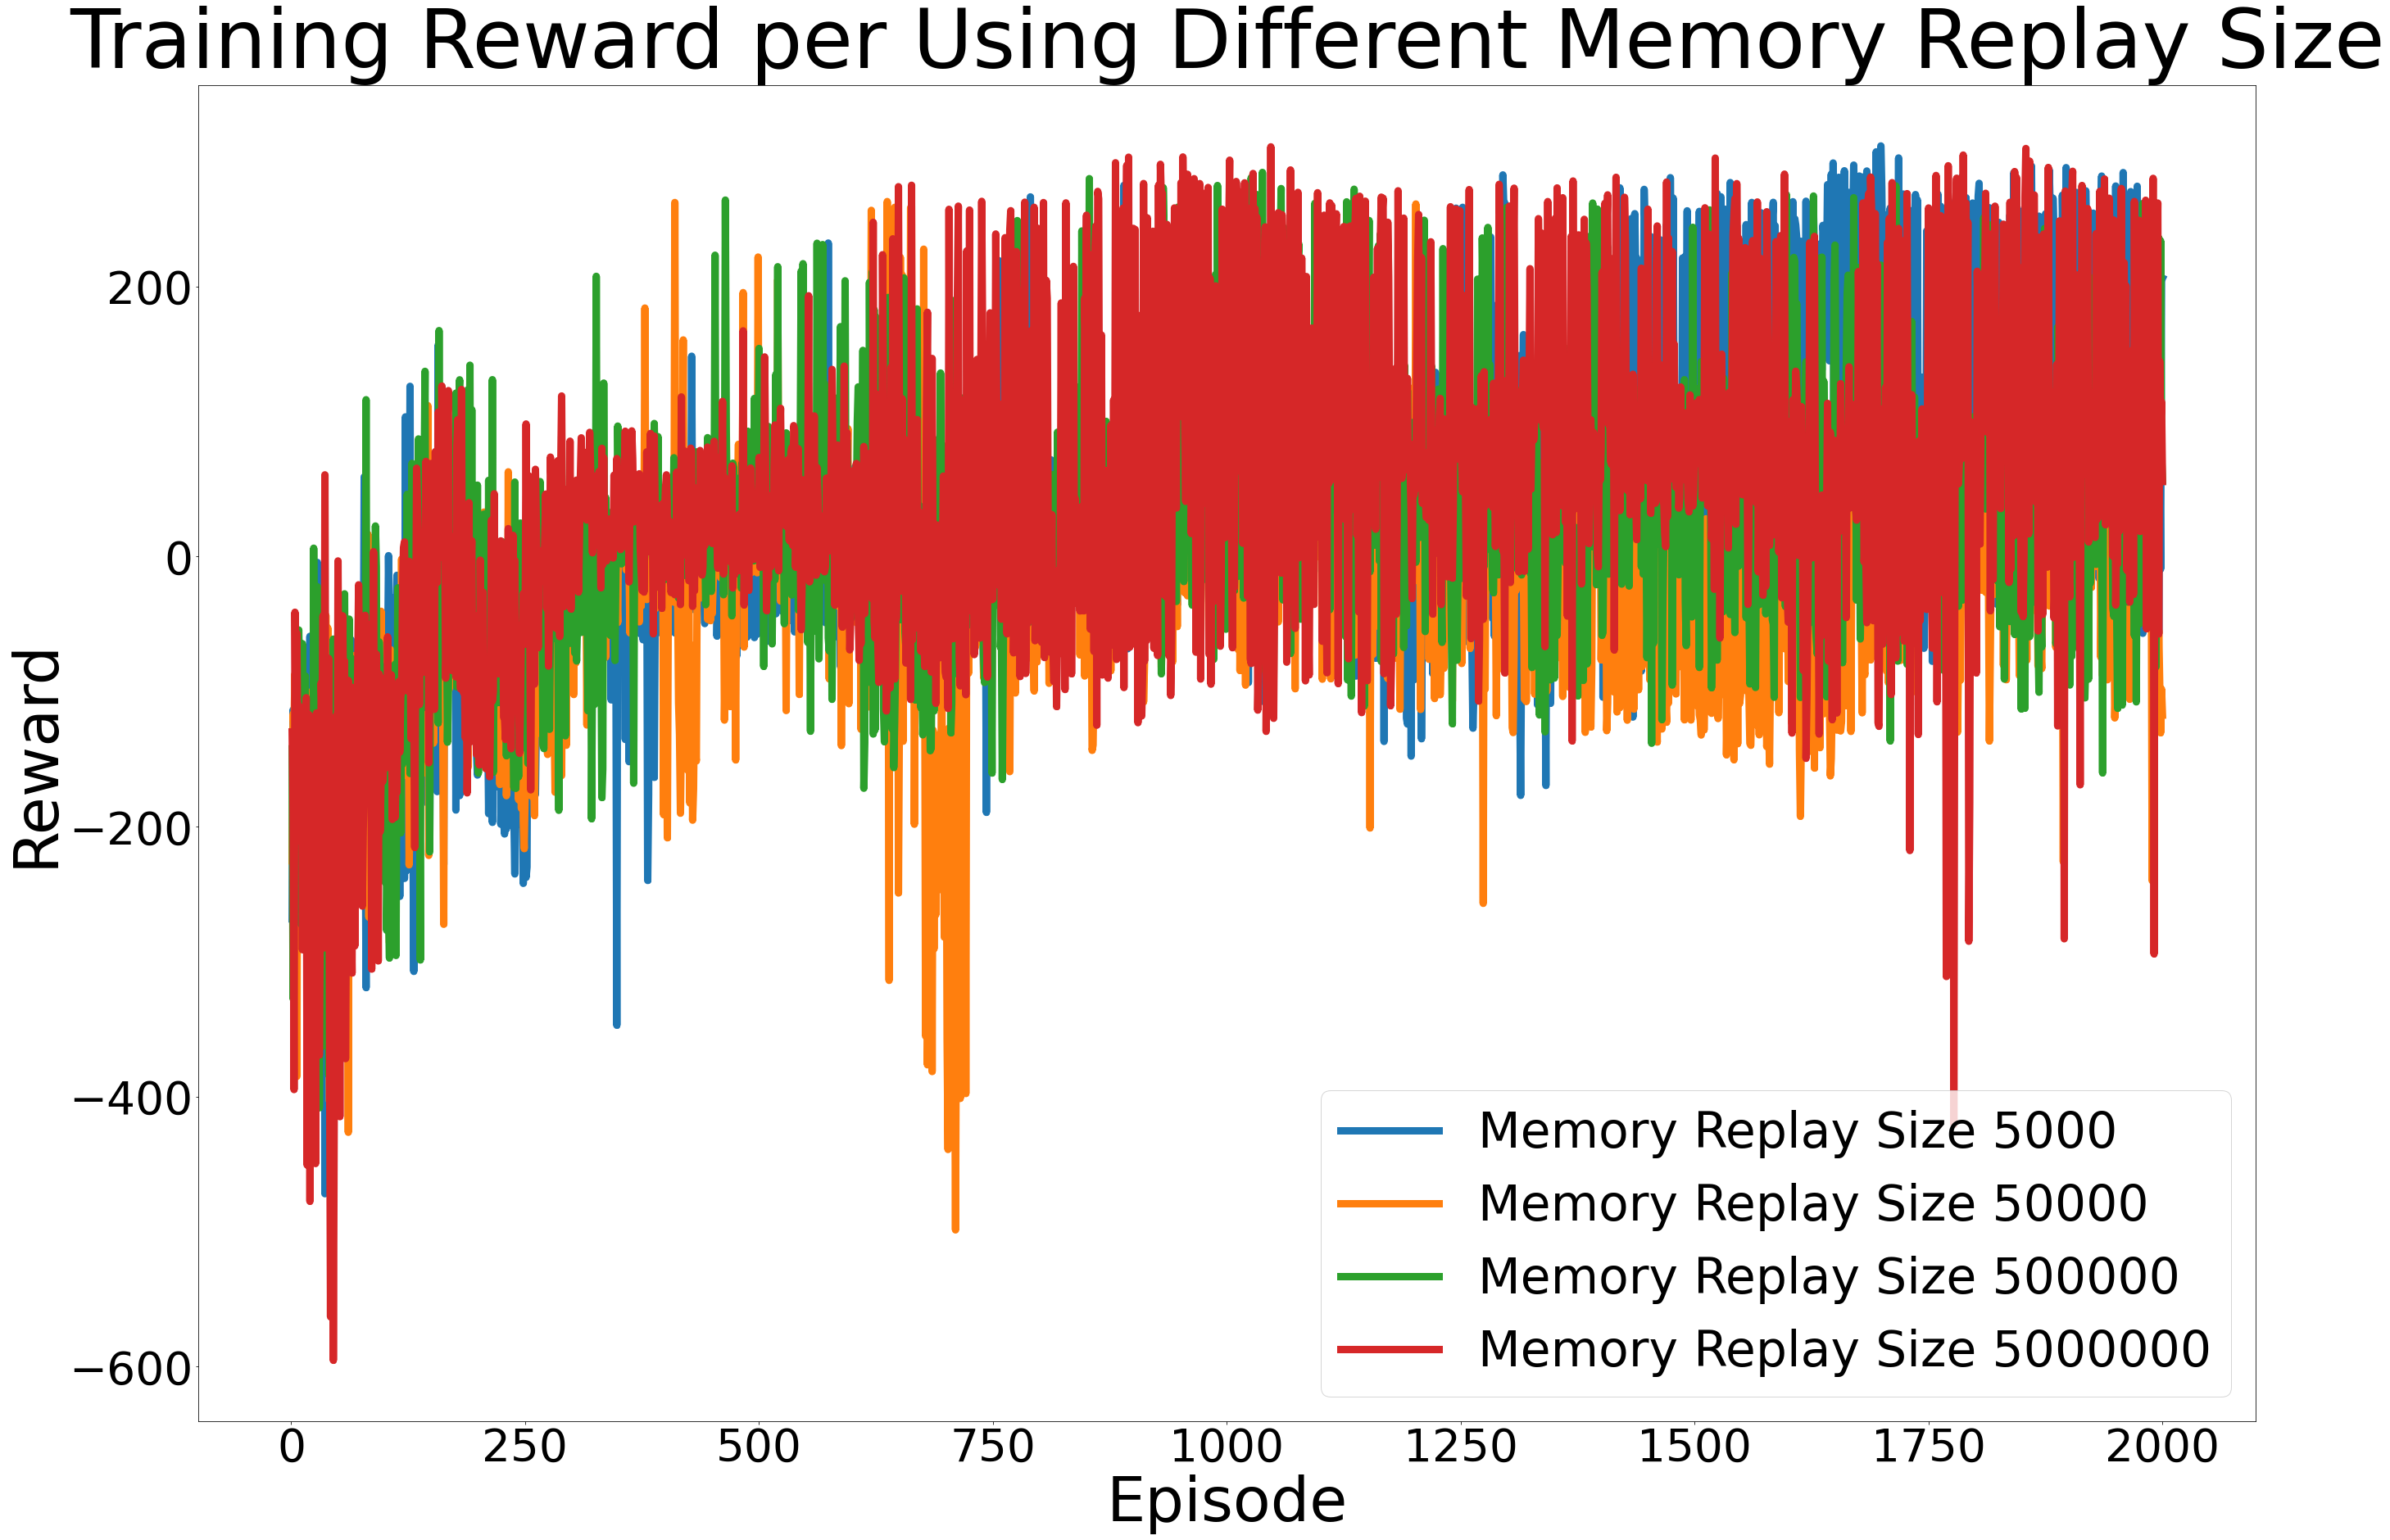

In [ ]:
#  Plot the rewards

import matplotlib.pyplot as plt

memory_replay_size = [5000,50000,500000,5000000]
plt.figure(figsize=(45,30))
for i in range(len(rewards_memoryReplay_size)):
  plt.plot(range(1,len(rewards_memoryReplay_size[i])+1),rewards_memoryReplay_size[i],'-o',linewidth=9, label = "Memory Replay Size "+ str(memory_replay_size[i]))
  #plt.plot([50*a for a in range(1,1+len(reward_50))],reward_50,'-o',linewidth=6, label = "Memory Replay Size "+ str(memory_replay_size[i]))

plt.ylabel('Reward',size=75)
plt.xlabel('Episode',size=75)
plt.title('Training Reward per Using Different Memory Replay Size',size=100)
plt.xticks(fontsize= 55)
plt.yticks(fontsize= 55)

plt.legend( prop={'size': 60})
plt.show()

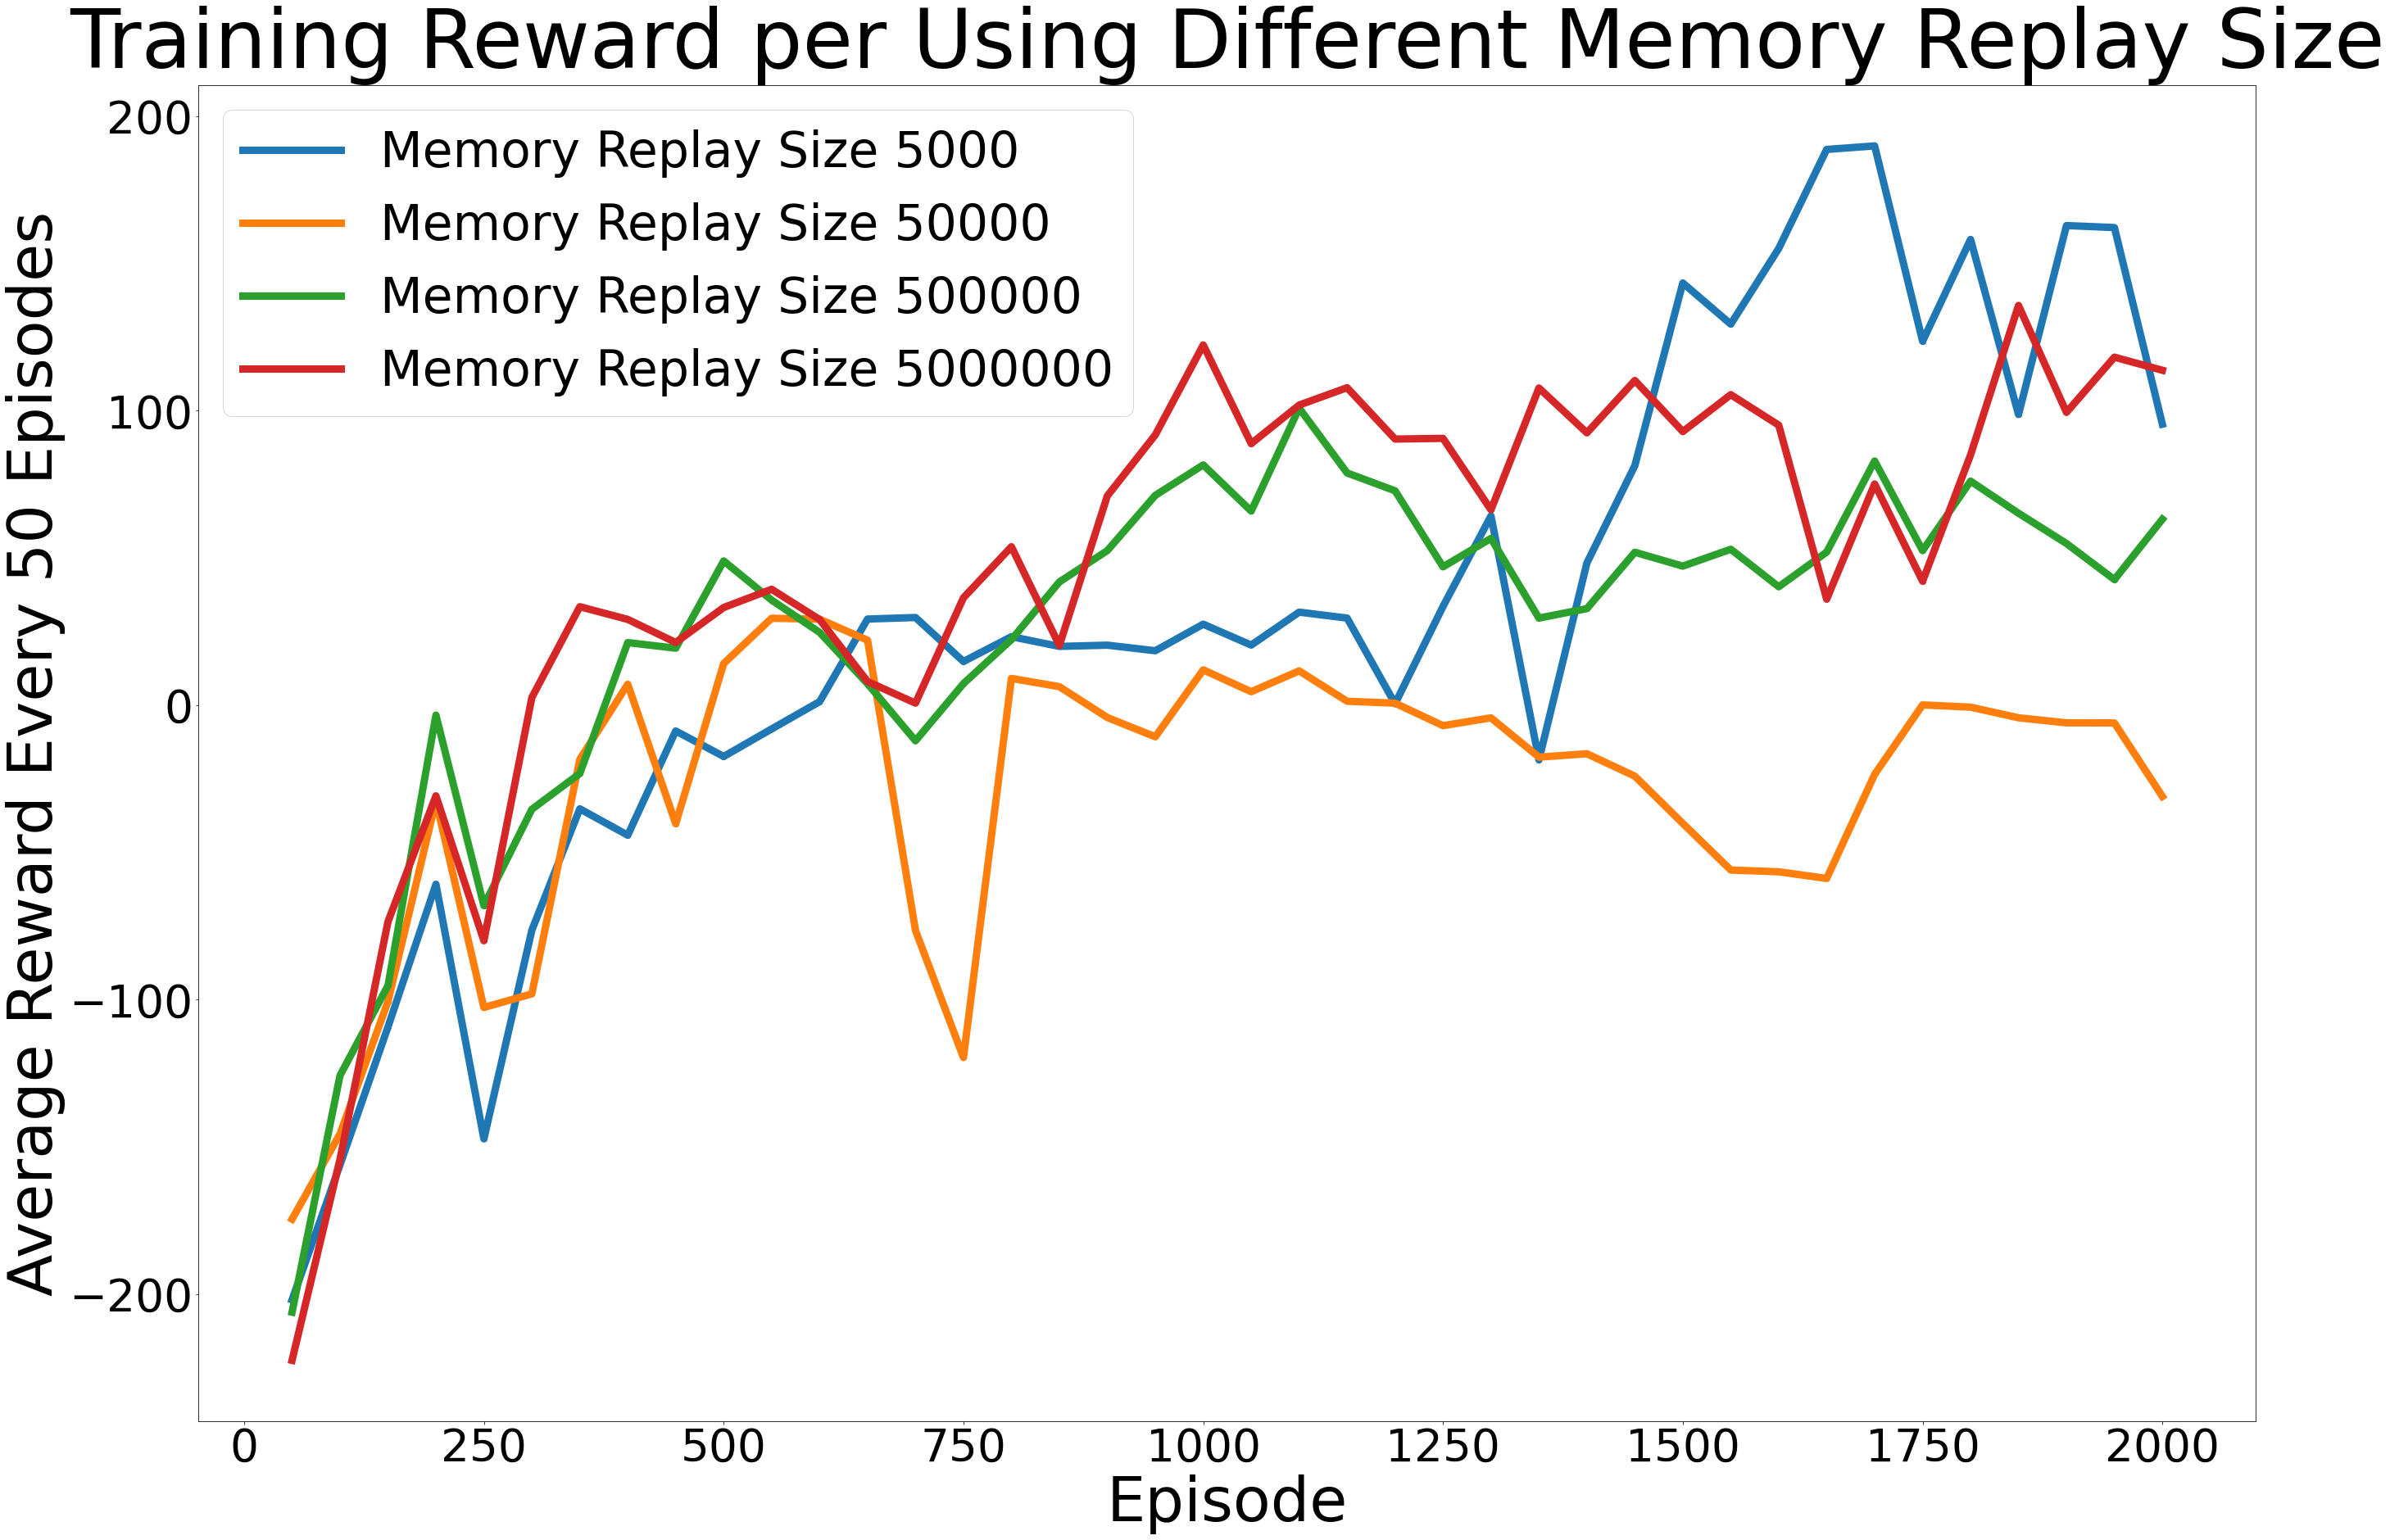

In [ ]:
#  Plot the average rewards

memory_replay_size = [5000,50000,500000,5000000]
plt.figure(figsize=(45,30))
for i in range(len(rewards_memoryReplay_size)):
  reward_50= []
  r = 0
  e = 0
  for j in range(len(rewards_memoryReplay_size[i])):
    r += rewards_memoryReplay_size[i][j]
    if (j+1)%50 == 0 or j == len(rewards_memoryReplay_size[i])-1:
      e += 1
      reward_50.append(r/(j - 50*e+51))
      r = 0
  plt.plot([50*a for a in range(1,1+len(reward_50))],reward_50,'-o',linewidth=9, label = "Memory Replay Size "+ str(memory_replay_size[i]))

plt.ylabel('Average Reward Every 50 Episodes',size=75)
plt.xlabel('Episode',size=75)
plt.title('Training Reward per Using Different Memory Replay Size',size=100)
plt.xticks(fontsize= 55)
plt.yticks(fontsize= 55)

plt.legend( prop={'size': 60})
plt.show()